In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet



import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

c:\Users\FAH\Documents\GitHub\timeseries_fc\notebooks\timeseries_lib\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
file_path = '../data/store_sales_train.csv'
df = pd.read_csv(file_path, index_col = "Date", low_memory=False, parse_dates=['Date'])
df_prof = df.copy()

In [3]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [5]:
#Choose Store 2 
df = df[df["Store"] == 2]
df = df.asfreq('D')
df.sort_values(by="Date", inplace=True)

### Split Data

In [6]:
#Split Data
train_size = int(len(df) * 0.8)
train_data = df[:train_size].copy(deep=True)
test_data = df[train_size:].copy(deep=True)

In [7]:
train_data['year'] = train_data.index.year
train_data['month'] = train_data.index.month
train_data['day'] = train_data.index.day

# Convert the columns to integers
train_data['year'] = train_data['year'].astype(int)
train_data['month'] = train_data['month'].astype(int)
train_data['day'] = train_data['day'].astype(int)

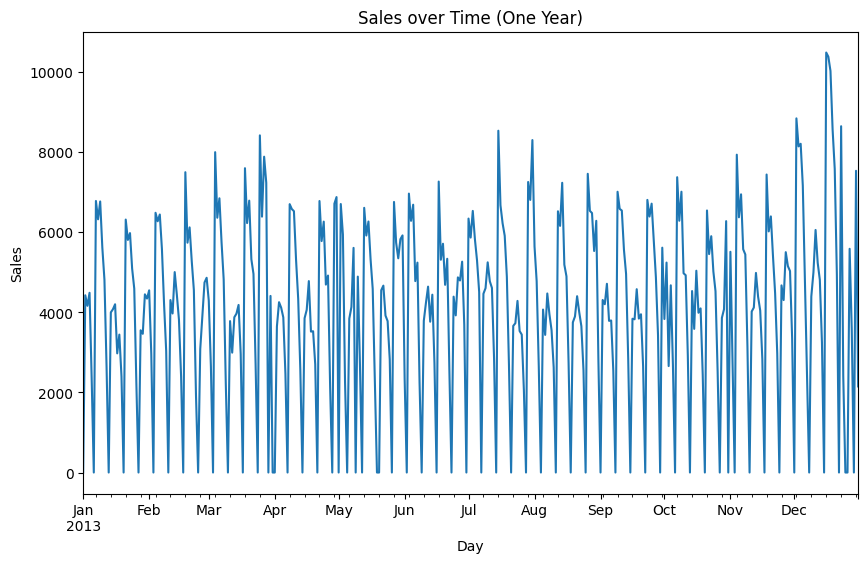

In [8]:
plt.figure(figsize=(10, 6))
train_data['Sales'][:365].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales over Time (One Year)')
plt.show()

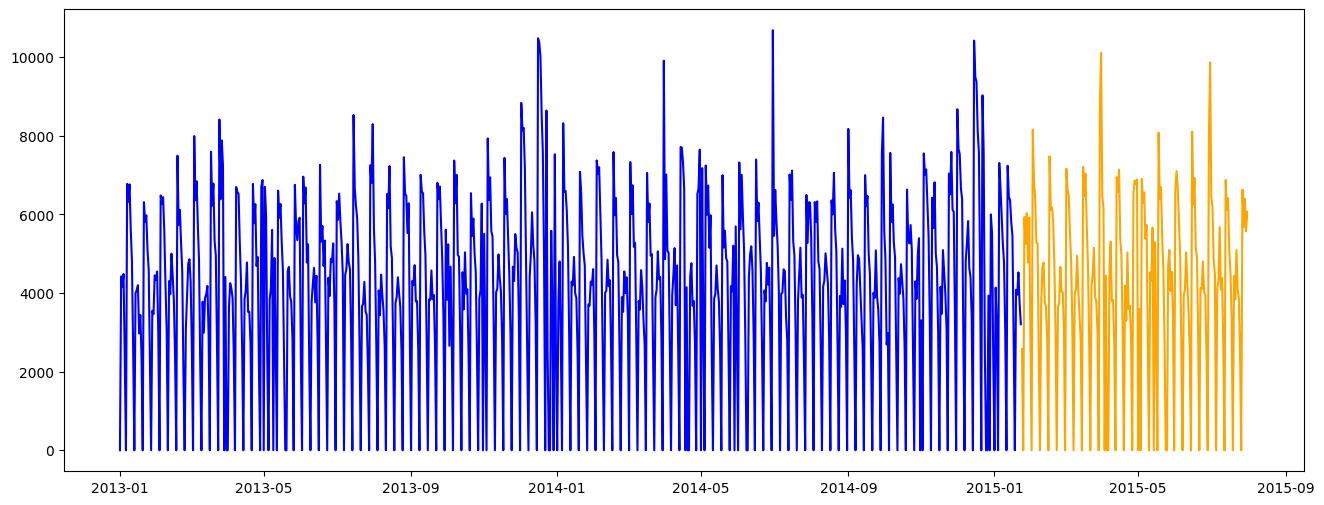

In [9]:
fig ,axes =plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes.plot(train_data["Sales"], label='Train',color='blue')
axes.plot(test_data["Sales"], label='Test',color='orange')
plt.show()

### Time Series Analysis and Forecasting with Prophet

In [10]:
df_prof = df_prof[(df_prof["Open"] != 0) & (df_prof['Sales'] != 0)]

# reset index to include 'Date' as a column
df_prof = df_prof.reset_index()

# sales for the store number 1 (StoreType C)
sales = df_prof[df_prof.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [11]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
843210,2013-01-02,5530
842101,2013-01-03,4327
840993,2013-01-04,4486
839886,2013-01-05,4997
838761,2013-01-07,7176


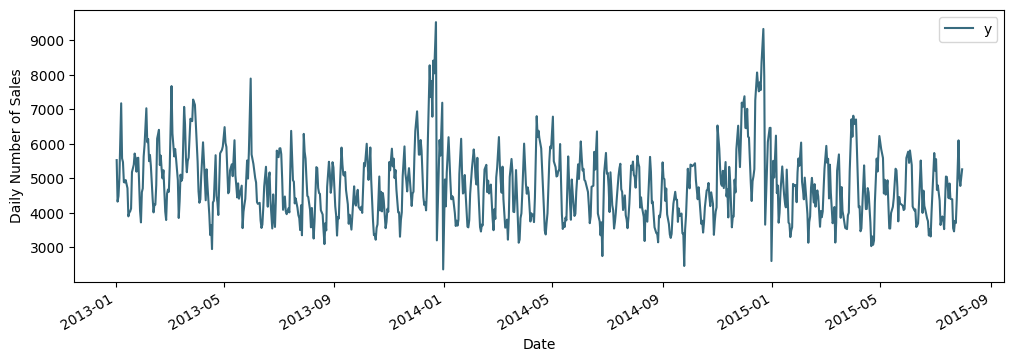

In [12]:
# plot daily sales
c = '#386B7F'
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [29]:
# create holidays dataframe with the distinct holidays and schoolvacation days for store = 1
state_dates = df_prof[(df_prof.Store == 1) & ((df_prof.StateHoliday == 'a') | (df_prof.StateHoliday == 'b') | (df_prof.StateHoliday == 'c'))].loc[:, 'Date'].values
school_dates = df_prof[(df_prof.Store == 1) & df_prof.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head(20)

,holiday,ds
0,school_holiday,2015-07-31
1,school_holiday,2015-07-30
2,school_holiday,2015-07-29
3,school_holiday,2015-07-28
4,school_holiday,2015-07-27
5,school_holiday,2015-04-10
6,school_holiday,2015-04-09
7,school_holiday,2015-04-08
8,school_holiday,2015-04-07
9,school_holiday,2015-04-04


In [25]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

19:56:36 - cmdstanpy - INFO - Chain [1] start processing
19:56:36 - cmdstanpy - INFO - Chain [1] done processing


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [15]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4109.292747,2460.918927,5755.365433
817,2015-09-06,4081.942351,2412.631898,5757.345791
818,2015-09-07,4179.728666,2597.667457,5769.154434
819,2015-09-08,3682.159219,2039.843875,5332.748891
820,2015-09-09,3568.378519,1915.208328,5125.122582
821,2015-09-10,3480.584575,1956.549335,4992.029895
822,2015-09-11,3735.707342,1923.303274,5245.286092


In [26]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

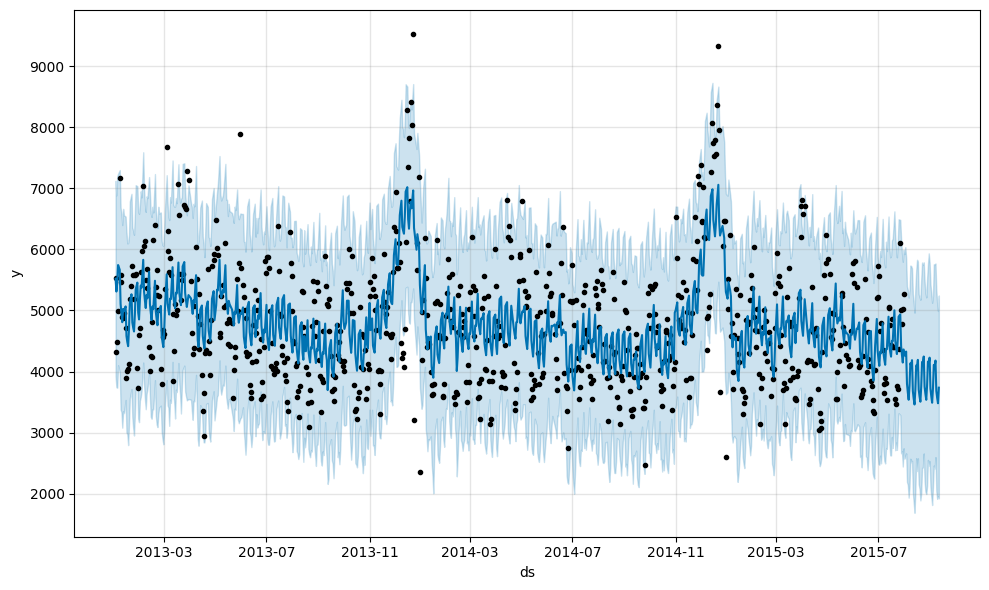

In [27]:
# visualizing predicions
my_model.plot(forecast);

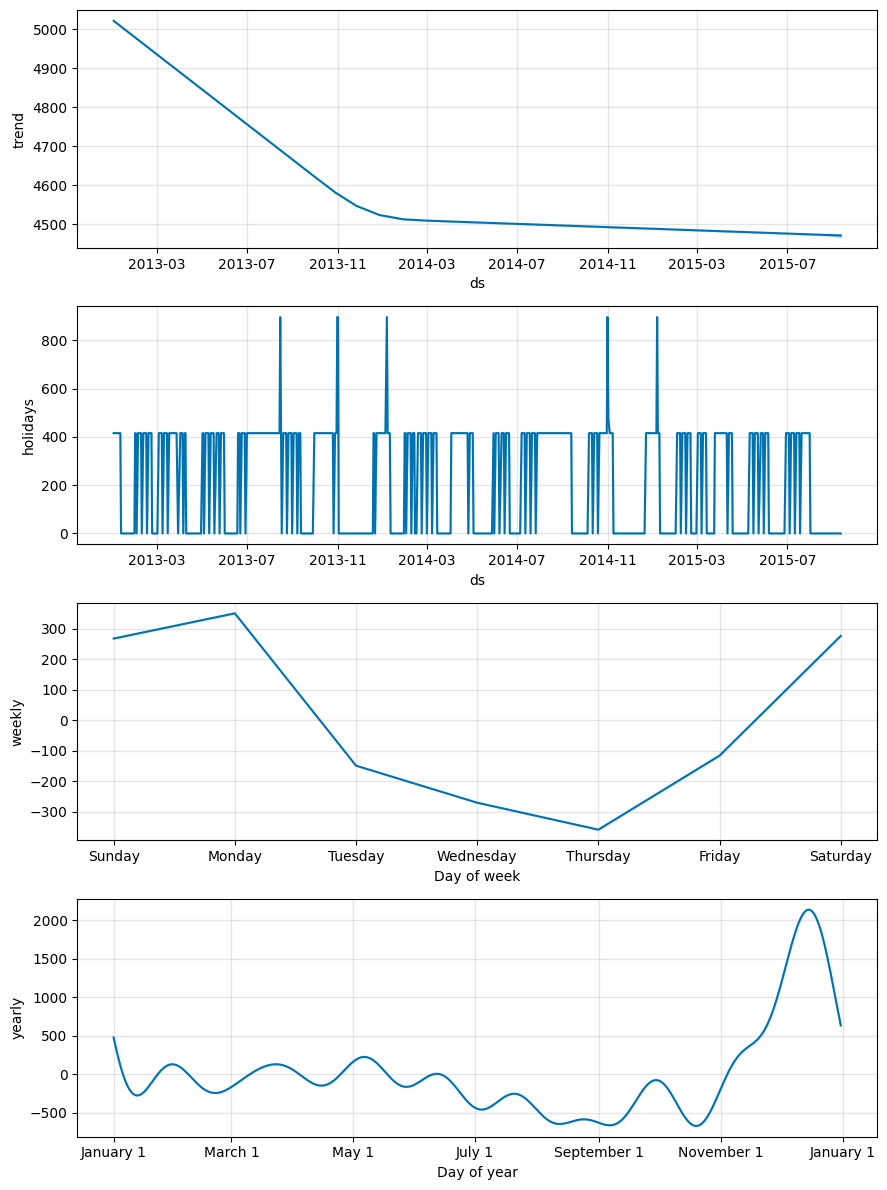

In [28]:
my_model.plot_components(forecast);

In [19]:
MAPE = np.mean(np.abs(np.array(test_data['Sales']) - np.array(fc['yhat'][:len(test_data)])) / np.mean(np.abs(np.array(test_data['Sales']))))
print('MAPE: ' + str(MAPE))



MAPE: 0.4620330132341203
